In [21]:
import glob
from platform import python_version
import matplotlib
import numpy as np
import pandas as pd
import sklearn
import torch
import heartpy
import biosppy
import time
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import scipy.io
from scipy.signal import savgol_filter
from scipy.signal import find_peaks

In [5]:
import sys
sys.path.append('..')
from transform.indexed_transform import IndexedTransformer
from transform.interpolate import SplineInterpolate
from transform.pca import PCATransformer
from transform.pca_tensors import PCATransformer_tensor
from transform.scale import ScaleTransform
from transform.series_to_curve import CurveProjection, IndicesWindow
from transform.transformer import SequentialTransformer
from transform.triangle_pattern import TrianglePattern


In [9]:
from add_func_pressure import transform_data
from add_func_pressure import plot_sequence
from add_func_pressure import generate_sequence
from add_func_pressure import to_dataframe


In [10]:
from Model.LSTM import Model
from Model.Optim import Optimization

ppg signal length 65000
ecg signal length 65000
abp signal length 65000


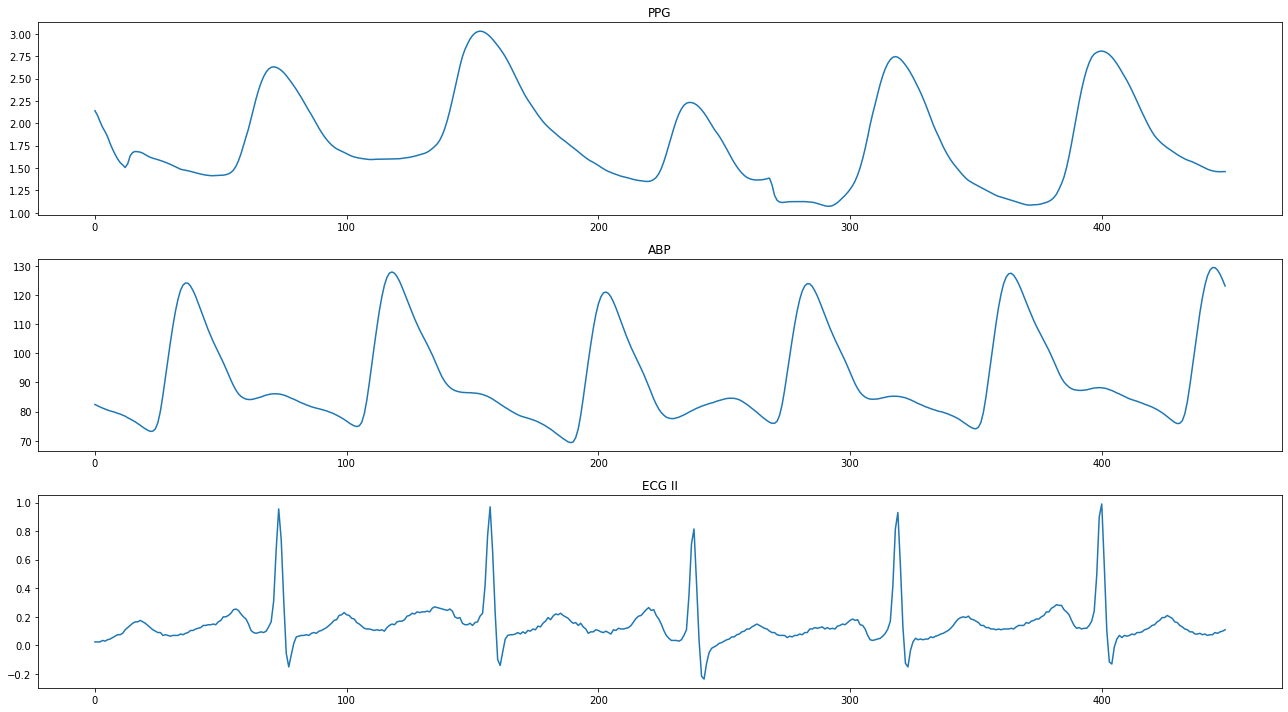

In [11]:
import heartpy as hp
mat = scipy.io.loadmat('blood_pressure_data/part_3.mat')
fig=plt.figure(figsize=(18,10))
plt.subplot(311)
plt.plot(mat['p'][0][0][0][450:900])
plt.title("PPG")
plt.subplot(312)
plt.plot(mat['p'][0][0][1][450:900])
plt.title("ABP")
plt.subplot(313)
plt.plot(mat['p'][0][0][2][450:900])
plt.title("ECG II")

plt.tight_layout()


print('ppg signal length',len(mat['p'][0][0][0]))
print('ecg signal length',len(mat['p'][0][0][2]))
print('abp signal length',len(mat['p'][0][0][1]))
ppg=mat['p'][0][0][0]
ecg=mat['p'][0][0][2]
abp=mat['p'][0][0][1]
wd_ppg, m_ppg = hp.process(ppg, sample_rate = 125.0)
wd_ecg, m_ecg = hp.process(ecg, sample_rate = 125.0)

In [12]:
projection_step = 1
smooth_transform = SequentialTransformer(
    ScaleTransform(0, 1),
    SplineInterpolate(0.02)
)

smooth_ecg=smooth_transform(ecg)
smooth_ppg=smooth_transform(ppg)
smooth_abp=smooth_transform(abp)

In [13]:
from sklearn.preprocessing import StandardScaler
seq_len = 300
x_train, y_train = transform_data(smooth_ecg, seq_len)
x_train_, y_train_ = transform_data(smooth_ppg, seq_len)

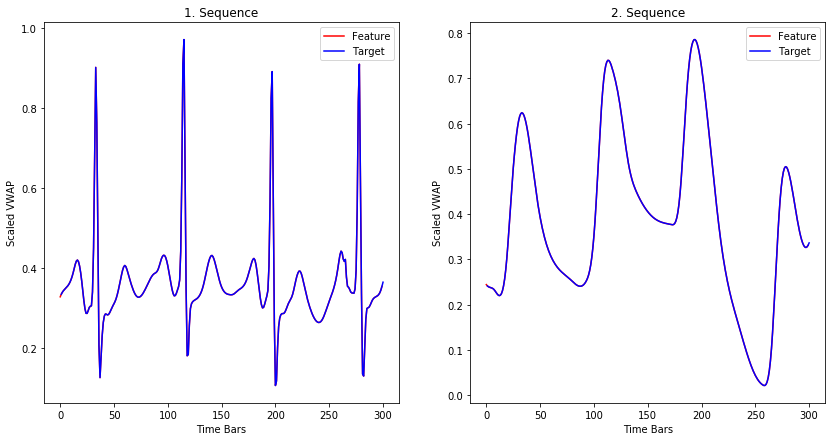

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))
plot_sequence(axes, 0, x_train, y_train,seq_len)
plot_sequence(axes, 1, x_train_, y_train_,seq_len)

In [19]:
model_1 =torch.load('weights/model_new_ppg_new_.ckpt')
model_1.load_state_dict(torch.load('weights/model_new_weights_ppg_new_.ckpt'))

# model_1 = Model(input_size=1, hidden_size=100, output_size=1)#if you train model again, use this row and comment weights downloading
loss_fn_1 = nn.MSELoss()
loss_fn_2 = nn.L1Loss()
optimizer_1 = optim.Adam(model_1.parameters(), lr=1e-3)
scheduler_1 = optim.lr_scheduler.StepLR(optimizer_1, step_size=4, gamma=0.1)
optimization_1 = Optimization(model_1, loss_fn_1, loss_fn_2,optimizer_1, scheduler_1)

In [17]:
optimization_1.train(x_train,x_train_, do_teacher_forcing=True)

Test loss 0.0423


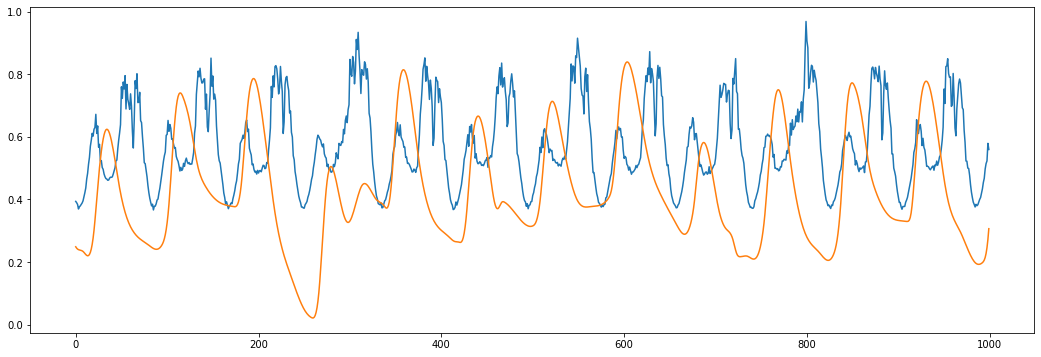

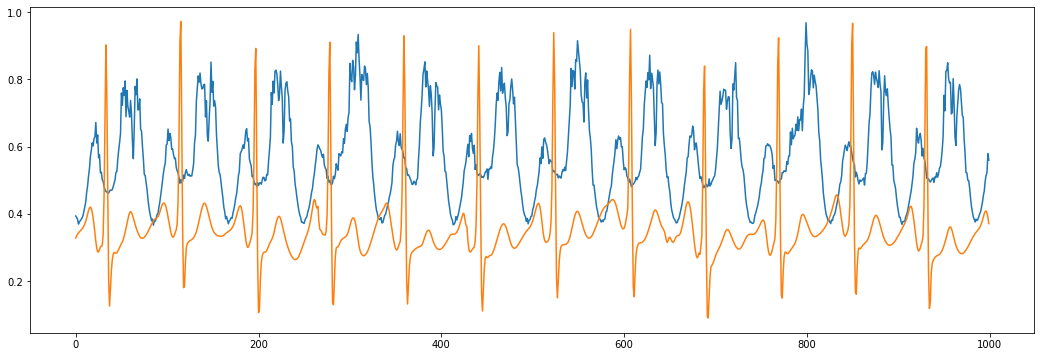

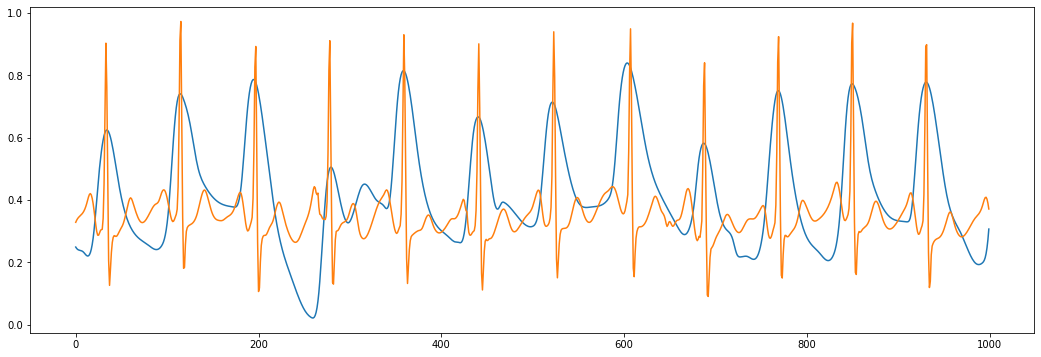

In [20]:
actual_1, predicted_1, test_loss_1 = optimization_1.evaluate(x_train, x_train_, future=5, batch_size=300)
df_result_1 = to_dataframe(actual_1, predicted_1) 
df_result_1[:1000]['predicted'].plot(figsize=(18, 6))
print("Test loss %.4f" % test_loss_1)
plt.plot(smooth_ppg[:1000])
plt.show()
df_result_1[:1000]['predicted'].plot(figsize=(18, 6))
plt.plot(smooth_ecg[:1000])
plt.show()
plt.figure(figsize=(18,6))
plt.plot(smooth_ppg[:1000])
plt.plot(smooth_ecg[:1000])
plt.show()

In [22]:
prediction=df_result_1['predicted']

yhat = savgol_filter(prediction, 51, 3) 

peaks, _ = find_peaks(yhat, height=np.mean(yhat)+np.std(yhat)/2)
peaks_ecg,_ = find_peaks(ecg, height=np.mean(ecg)+1.2*np.std(ecg))
peaks_ECG = biosppy.signals.ecg.christov_segmenter(signal=ecg, sampling_rate=125)[0]
peaks_abp, _ = find_peaks(abp, height=np.mean(abp)+np.std(abp)/2)
peaks_abp_min, _ = find_peaks(-1*(abp),height=np.mean(-1*(abp))+0.89*np.std(-1*(abp)))

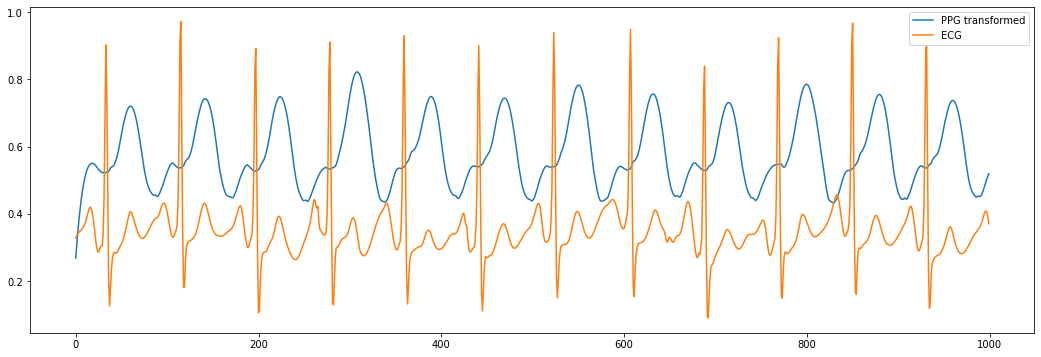

In [28]:
fig=plt.figure(figsize=(18,6))
plt.plot(yhat[:1000],label='PPG transformed')
plt.plot(smooth_ecg[:1000],label='ECG')
plt.legend()
plt.show()